# Installs

In [1]:
# Install packages
required_packages <- c(
  "gamlss", "forecast", "ggplot2", "dplyr", "tidyr",
  "lubridate", "gamlss.dist", "zoo", "tseries", "splines",
  "reshape2"
)

for (pkg in required_packages) {
  if (!require(pkg, character.only = TRUE)) {
    install.packages(pkg, dependencies = TRUE)
  }
}

# Load libraries
library(gamlss)
library(forecast)
library(ggplot2)
library(dplyr)
library(tidyr)
library(lubridate)
library(gamlss.dist)
library(zoo)
library(tseries)
library(splines)
library(reshape2)
library(scales)
library(stringr)

Loading required package: gamlss

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘gamlss’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘gamlss.data’, ‘gamlss.dist’, ‘distributions3’


Loading required package: forecast

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘forecast’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘TTR’, ‘quadprog’, ‘quantmod’, ‘x13binary’, ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘tseries’, ‘urca’, ‘zoo’, ‘RcppArmadillo’, ‘forecTheta’, ‘rticles’, ‘seasonal’, ‘uroot’


Loading required package: ggplot2

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following obje

# Data Loading

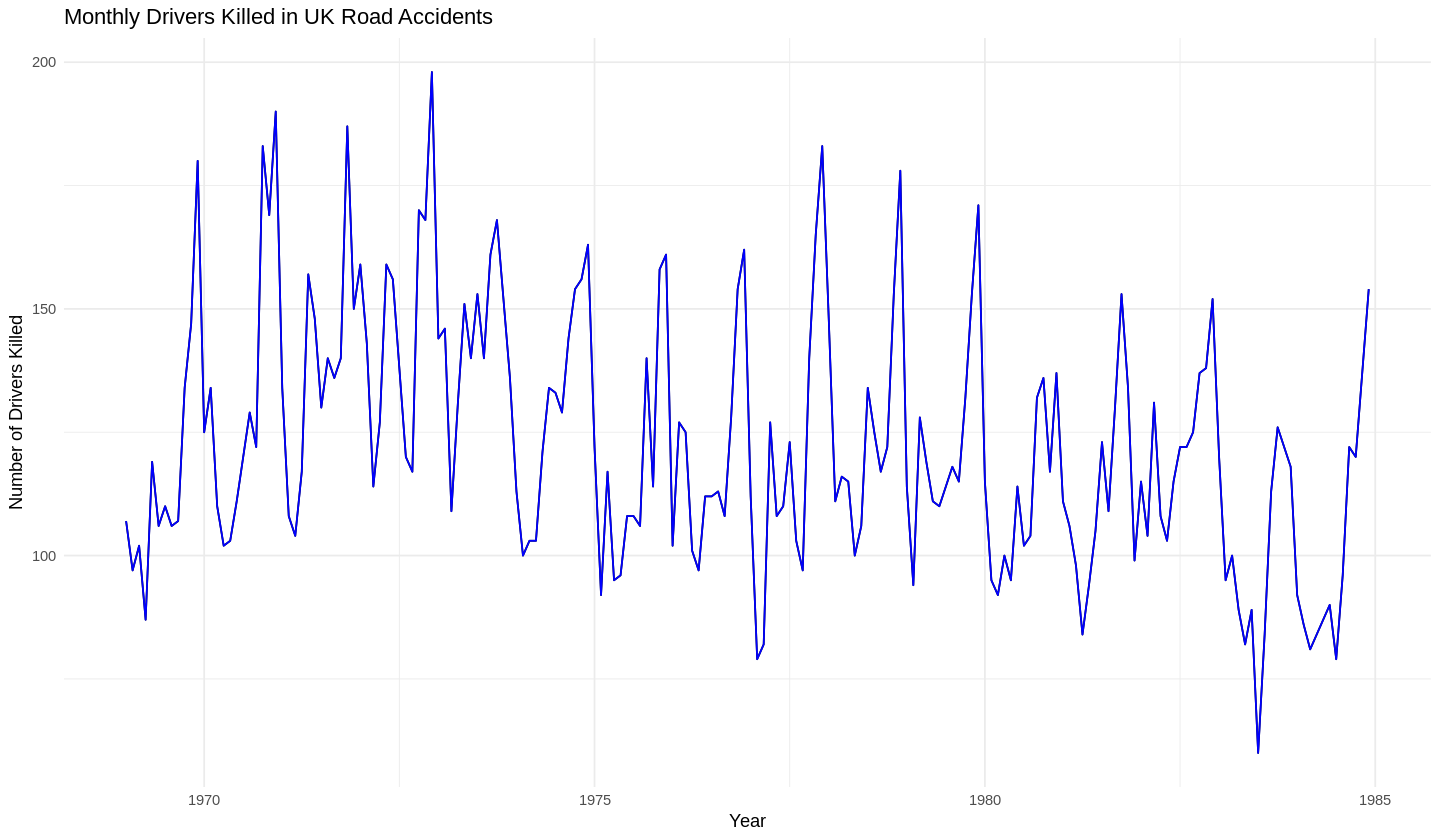

In [2]:
# Load the Seatbelts dataset
data("Seatbelts")

# Extract the "DriversKilled" variable
drivers_killed_ts <- Seatbelts[, "DriversKilled"]

# Plot the time series
options(repr.plot.width = 12, repr.plot.height = 7)
autoplot(drivers_killed_ts) +
  geom_line(color = "blue") +
  ggtitle("Monthly Drivers Killed in UK Road Accidents") +
  xlab("Year") + ylab("Number of Drivers Killed") +
  theme_minimal()

In [3]:
# Convert the time series to a dataframe
df <- data.frame(
  date = as.Date(as.yearmon(time(drivers_killed_ts))),
  drivers_killed = as.numeric(drivers_killed_ts)
)

head(df)
cat("\n")
tail(df)

,date,drivers_killed
,<date>,<dbl>
1,1969-01-01,107
2,1969-02-01,97
3,1969-03-01,102
4,1969-04-01,87
5,1969-05-01,119
6,1969-06-01,106


,date,drivers_killed
,<date>,<dbl>
187,1984-07-01,79
188,1984-08-01,96
189,1984-09-01,122
190,1984-10-01,120
191,1984-11-01,137
192,1984-12-01,154


In [4]:
# Include exogenous variables
df$PetrolPrice <- as.numeric(Seatbelts[, "PetrolPrice"])
df$kms <- as.numeric(Seatbelts[, "kms"])

head(df)

,date,drivers_killed,PetrolPrice,kms
,<date>,<dbl>,<dbl>,<dbl>
1,1969-01-01,107,0.1029718,9059
2,1969-02-01,97,0.1023630,7685
3,1969-03-01,102,0.1020625,9963
4,1969-04-01,87,0.1008733,10955
5,1969-05-01,119,0.1010197,11823
6,1969-06-01,106,0.1005812,12391


# Data Exploration

In [5]:
# Check for stationarity using Augmented Dickey-Fuller test
adf_test <- adf.test(df$drivers_killed)
print(adf_test)

Warning message in adf.test(df$drivers_killed):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  df$drivers_killed
Dickey-Fuller = -6.1975, Lag order = 5, p-value = 0.01
alternative hypothesis: stationary



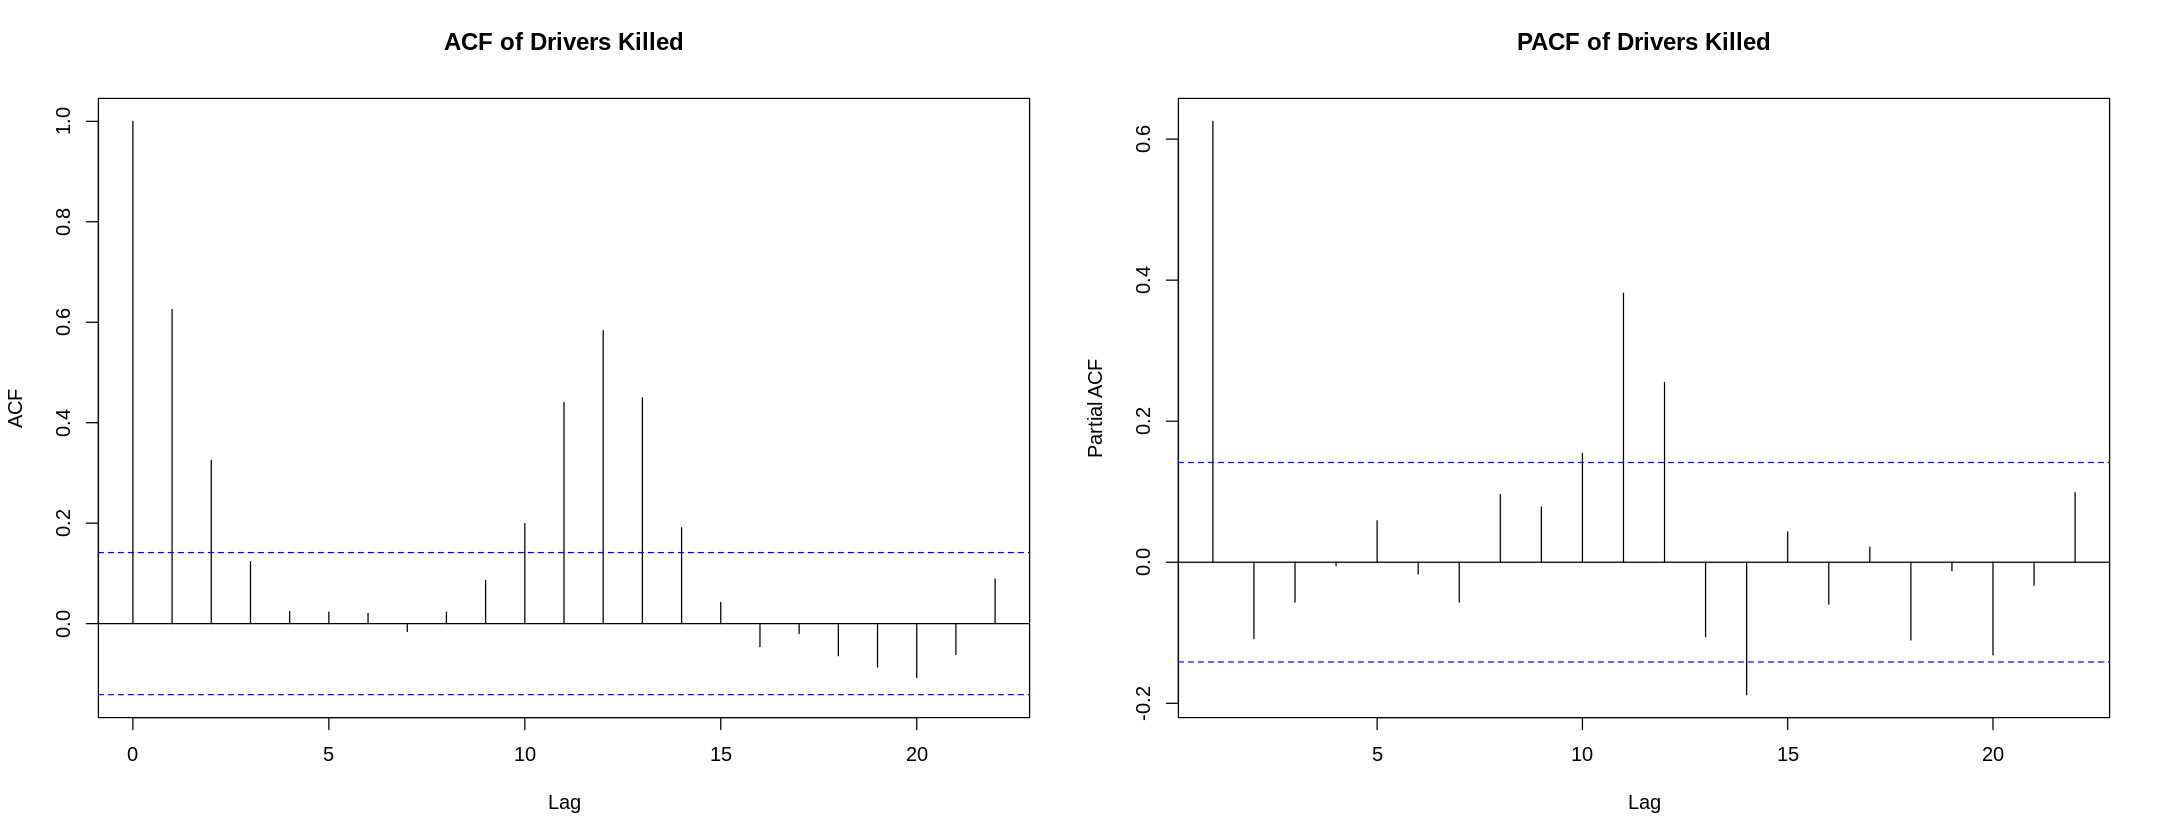

In [6]:
# Plot ACF and PACF
options(repr.plot.width = 18, repr.plot.height = 7)
par(mfrow = c(1, 2))
acf(df$drivers_killed, main = "ACF of Drivers Killed")
pacf(df$drivers_killed, main = "PACF of Drivers Killed")
par(mfrow = c(1,1))

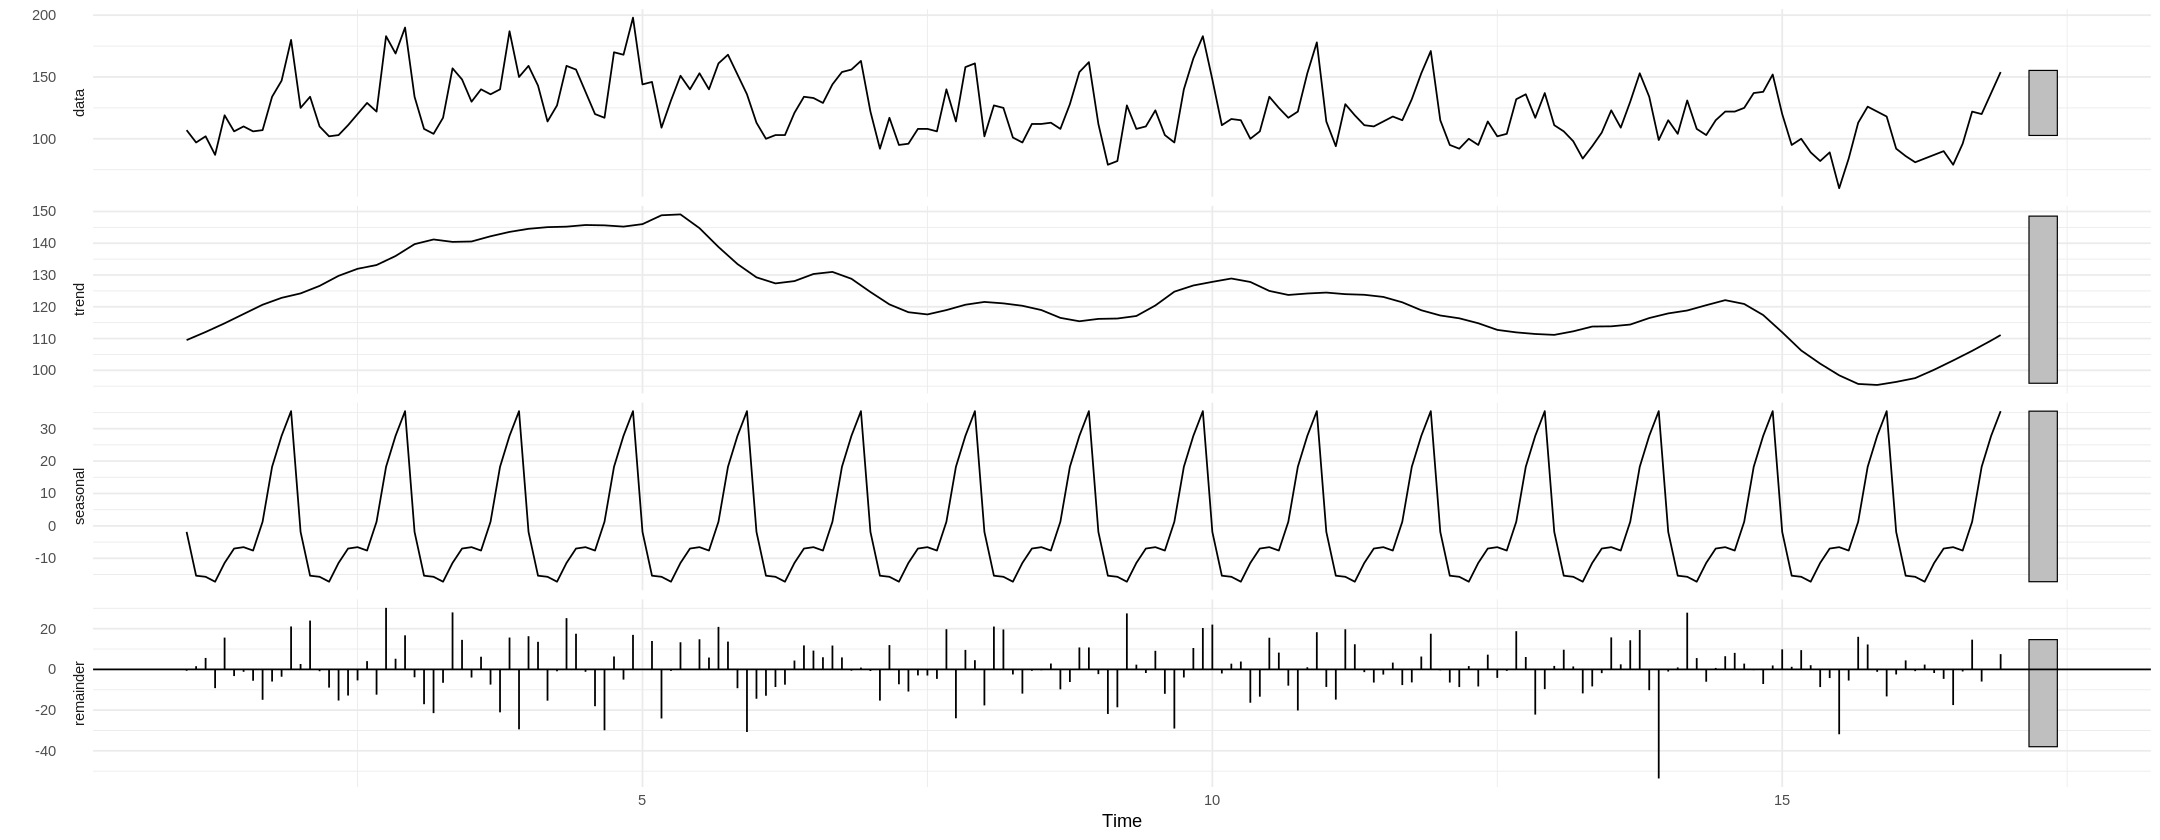

In [7]:
# Decompose the time series to check for seasonality
decomp <- stl(ts(df$drivers_killed, frequency = 12), s.window = "periodic")
autoplot(decomp) + theme_minimal()

# Variable Creation

In [8]:
# Create lag variables for the target variable
lag_steps <- c(1, 3, 6, 12)
for (i in lag_steps) {
  df[[paste0("lag_drivers_killed_", i)]] <- lag(df$drivers_killed, i)
}

# Create lagged exogenous variables
for (i in lag_steps) {
  df[[paste0("lag_PetrolPrice_", i)]] <- lag(df$PetrolPrice, i)
  df[[paste0("lag_kms_", i)]] <- lag(df$kms, i)
}

head(df)

,date,drivers_killed,PetrolPrice,kms,lag_drivers_killed_1,lag_drivers_killed_3,lag_drivers_killed_6,lag_drivers_killed_12,lag_PetrolPrice_1,lag_kms_1,lag_PetrolPrice_3,lag_kms_3,lag_PetrolPrice_6,lag_kms_6,lag_PetrolPrice_12,lag_kms_12
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1969-01-01,107,0.1029718,9059,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,1969-02-01,97,0.1023630,7685,107,NA,NA,NA,0.1029718,9059,NA,NA,NA,NA,NA,NA
3,1969-03-01,102,0.1020625,9963,97,NA,NA,NA,0.1023630,7685,NA,NA,NA,NA,NA,NA
4,1969-04-01,87,0.1008733,10955,102,107,NA,NA,0.1020625,9963,0.1029718,9059,NA,NA,NA,NA
5,1969-05-01,119,0.1010197,11823,87,97,NA,NA,0.1008733,10955,0.1023630,7685,NA,NA,NA,NA
6,1969-06-01,106,0.1005812,12391,119,102,NA,NA,0.1010197,11823,0.1020625,9963,NA,NA,NA,NA


In [9]:
# Add trend variable
df$trend <- 1:nrow(df)

# Ensure that 'month' has consistent levels
df$month <- factor(month(df$date, label=TRUE), levels=month.abb)

# Add harmonic terms for seasonality
df$month_sin <- sin(2 * pi * df$trend / 12)
df$month_cos <- cos(2 * pi * df$trend / 12)

# Remove rows with NA due to lagging
df <- df %>% drop_na()

head(df)

,date,drivers_killed,PetrolPrice,kms,lag_drivers_killed_1,lag_drivers_killed_3,lag_drivers_killed_6,lag_drivers_killed_12,lag_PetrolPrice_1,lag_kms_1,lag_PetrolPrice_3,lag_kms_3,lag_PetrolPrice_6,lag_kms_6,lag_PetrolPrice_12,lag_kms_12,trend,month,month_sin,month_cos
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<ord>,<dbl>,<dbl>
1,1970-01-01,125,0.10127456,9130,180,134,110,107,0.10199719,9267,0.1030264,11372,0.1037740,13460,0.1029718,9059,13,Jan,5.000000e-01,8.660254e-01
2,1970-02-01,134,0.10070398,8933,125,147,106,97,0.10127456,9130,0.1027301,9834,0.1040764,14055,0.1023630,7685,14,Feb,8.660254e-01,5.000000e-01
3,1970-03-01,110,0.10013961,11000,134,180,107,102,0.10070398,8933,0.1019972,9267,0.1037740,12106,0.1020625,9963,15,Mar,1.000000e+00,1.194340e-15
4,1970-04-01,102,0.09862110,10733,110,125,134,87,0.10013961,11000,0.1012746,9130,0.1030264,11372,0.1008733,10955,16,Apr,8.660254e-01,-5.000000e-01
5,1970-05-01,103,0.09834929,12912,102,134,147,119,0.09862110,10733,0.1007040,8933,0.1027301,9834,0.1010197,11823,17,May,5.000000e-01,-8.660254e-01
6,1970-06-01,111,0.09808018,12926,103,110,180,106,0.09834929,12912,0.1001396,11000,0.1019972,9267,0.1005812,12391,18,Jun,3.673940e-16,-1.000000e+00


# Data Splitting

In [10]:
# Split the data into training (80%) and testing (20%) sets
split_index <- floor(0.8 * nrow(df))
train_data <- df[1:split_index, ]
test_data <- df[(split_index + 1):nrow(df), ]

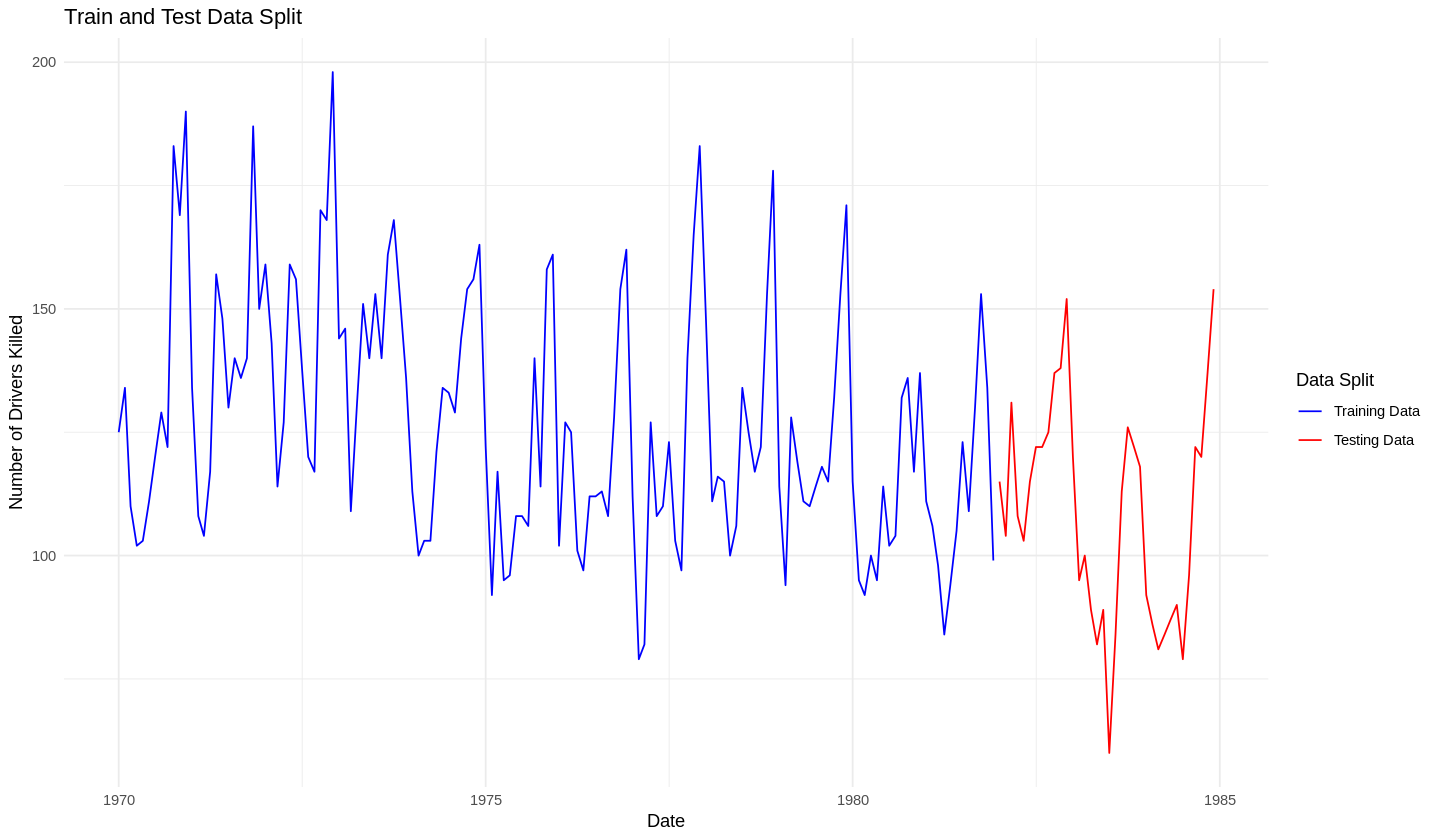

In [11]:
# Visualize the training and testing splits
options(repr.plot.width = 12, repr.plot.height = 7)
ggplot() +
  geom_line(data = train_data, aes(x = date, y = drivers_killed, color = "Training Data")) +
  geom_line(data = test_data, aes(x = date, y = drivers_killed, color = "Testing Data")) +
  ggtitle("Train and Test Data Split") +
  xlab("Date") + ylab("Number of Drivers Killed") +
  scale_color_manual(
    name = "Data Split",
    values = c("Testing Data" = "red", "Training Data" = "blue")
  ) +
  theme_minimal() +
  guides(color = guide_legend(reverse=TRUE))

# Spline Functions

In [12]:
# Create spline basis functions for 'trend'
spline_basis_train <- ns(train_data$trend, df = 4)
spline_basis_train_df <- as.data.frame(spline_basis_train)
colnames(spline_basis_train_df) <- paste0("trend_ns", 1:ncol(spline_basis_train_df))

# Combine the spline basis functions with the training data
train_data <- cbind(train_data, spline_basis_train_df)

head(train_data)

,date,drivers_killed,PetrolPrice,kms,lag_drivers_killed_1,lag_drivers_killed_3,lag_drivers_killed_6,lag_drivers_killed_12,lag_PetrolPrice_1,lag_kms_1,⋯,lag_PetrolPrice_12,lag_kms_12,trend,month,month_sin,month_cos,trend_ns1,trend_ns2,trend_ns3,trend_ns4
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<int>,<ord>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1970-01-01,125,0.10127456,9130,180,134,110,107,0.10199719,9267,⋯,0.1029718,9059,13,Jan,5.000000e-01,8.660254e-01,0.000000e+00,0.000000000,0.00000000,0.00000000
2,1970-02-01,134,0.10070398,8933,125,147,106,97,0.10127456,9130,⋯,0.1023630,7685,14,Feb,8.660254e-01,5.000000e-01,3.647713e-06,-0.007090354,0.02127106,-0.01418071
3,1970-03-01,110,0.10013961,11000,134,180,107,102,0.10070398,8933,⋯,0.1020625,9963,15,Mar,1.000000e+00,1.194340e-15,2.918170e-05,-0.014169609,0.04250883,-0.02833922
4,1970-04-01,102,0.09862110,10733,110,125,134,87,0.10013961,11000,⋯,0.1008733,10955,16,Apr,8.660254e-01,-5.000000e-01,9.848824e-05,-0.021226668,0.06368000,-0.04245334
5,1970-05-01,103,0.09834929,12912,102,134,147,119,0.09862110,10733,⋯,0.1010197,11823,17,May,5.000000e-01,-8.660254e-01,2.334536e-04,-0.028250432,0.08475129,-0.05650086
6,1970-06-01,111,0.09808018,12926,103,110,180,106,0.09834929,12912,⋯,0.1005812,12391,18,Jun,3.673940e-16,-1.000000e+00,4.559641e-04,-0.035229802,0.10568941,-0.07045960


In [13]:
# Use the spline basis functions from the training data to transform the test data
spline_basis_test <- predict(spline_basis_train, newx = test_data$trend)
spline_basis_test_df <- as.data.frame(spline_basis_test)
colnames(spline_basis_test_df) <- colnames(spline_basis_train_df)

# Combine the spline basis functions with the test data
test_data <- cbind(test_data, spline_basis_test_df)

head(test_data)

,date,drivers_killed,PetrolPrice,kms,lag_drivers_killed_1,lag_drivers_killed_3,lag_drivers_killed_6,lag_drivers_killed_12,lag_PetrolPrice_1,lag_kms_1,⋯,lag_PetrolPrice_12,lag_kms_12,trend,month,month_sin,month_cos,trend_ns1,trend_ns2,trend_ns3,trend_ns4
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<int>,<ord>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
145,1982-01-01,115,0.1127503,13601,99,153,123,111,0.1169686,13544,⋯,0.1047603,15226,157,Jan,5.000000e-01,8.660254e-01,0,-0.1728272,0.4345654,0.7382617
146,1982-02-01,104,0.1080793,15667,115,134,109,106,0.1127503,13601,⋯,0.1040025,14932,158,Feb,8.660254e-01,5.000000e-01,0,-0.2027972,0.4405594,0.7622378
147,1982-03-01,131,0.1088385,17358,104,99,130,98,0.1080793,15667,⋯,0.1166555,16846,159,Mar,1.000000e+00,1.468957e-15,0,-0.2327672,0.4465534,0.7862138
148,1982-04-01,108,0.1112918,18112,131,115,153,84,0.1088385,17358,⋯,0.1151615,16854,160,Apr,8.660254e-01,-5.000000e-01,0,-0.2627373,0.4525475,0.8101898
149,1982-05-01,103,0.1113040,18581,108,104,134,94,0.1112918,18112,⋯,0.1129895,18146,161,May,5.000000e-01,-8.660254e-01,0,-0.2927073,0.4585415,0.8341658
150,1982-06-01,115,0.1154544,18759,103,131,99,105,0.1113040,18581,⋯,0.1138606,17559,162,Jun,6.859260e-15,-1.000000e+00,0,-0.3226773,0.4645355,0.8581419


# Model Fitting

In [14]:
# Check for overdispersion in count data
mean_count <- mean(train_data$drivers_killed)
var_count <- var(train_data$drivers_killed)
cat("Mean:", mean_count, "\n")
cat("Variance:", var_count, "\n")

Mean: 126.9306 
Variance: 615.114 


In [15]:
# Use Negative Binomial if overdispersion is present
if (var_count > mean_count) {
  family_dist <- NBI()
  cat("Using Negative Binomial distribution.\n")
} else {
  family_dist <- PO()
  cat("Using Poisson distribution.\n")
}

Using Negative Binomial distribution.


In [16]:
# Define the formula for the GAMLSS model
spline_vars <- colnames(spline_basis_train_df)
lag_vars <- paste0("lag_drivers_killed_", lag_steps)
lag_exog_vars <- c(paste0("lag_PetrolPrice_", lag_steps), paste0("lag_kms_", lag_steps))
all_predictors <- c(spline_vars, "month_sin", "month_cos", lag_vars, lag_exog_vars)
formula_mu <- as.formula(paste("drivers_killed ~", paste(all_predictors, collapse = " + ")))

In [17]:
# Fit the GAMLSS model on the training data
gamlss_model <- gamlss(
  formula = formula_mu,
  family = family_dist,
  data = train_data,
  control = gamlss.control(n.cyc = 100)
)

# Model summary
summary(gamlss_model)

GAMLSS-RS iteration 1: Global Deviance = 1188.427 
GAMLSS-RS iteration 2: Global Deviance = 1188.362 
GAMLSS-RS iteration 3: Global Deviance = 1188.362 
******************************************************************
Family:  c("NBI", "Negative Binomial type I") 

Call:  gamlss(formula = formula_mu, family = family_dist,  
    data = train_data, control = gamlss.control(n.cyc = 100)) 

Fitting method: RS() 

------------------------------------------------------------------
Mu link function:  log
Mu Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)            5.194e+00  4.978e-01  10.432  < 2e-16 ***
trend_ns1             -2.731e-02  1.179e-01  -0.232  0.81726    
trend_ns2              6.762e-02  1.274e-01   0.531  0.59658    
trend_ns3              3.289e-01  2.963e-01   1.110  0.26909    
trend_ns4             -2.221e-02  1.694e-01  -0.131  0.89590    
month_sin             -4.390e-02  5.791e-02  -0.758  0.44982    
month_cos              

In [18]:
# Print the model
print(gamlss_model)


Family:  c("NBI", "Negative Binomial type I") 
Fitting method: RS() 

Call:  gamlss(formula = formula_mu, family = family_dist,  
    data = train_data, control = gamlss.control(n.cyc = 100)) 

Mu Coefficients:
          (Intercept)              trend_ns1              trend_ns2  
            5.194e+00             -2.731e-02              6.762e-02  
            trend_ns3              trend_ns4              month_sin  
            3.289e-01             -2.221e-02             -4.390e-02  
            month_cos   lag_drivers_killed_1   lag_drivers_killed_3  
            1.089e-01              1.036e-03             -1.409e-03  
 lag_drivers_killed_6  lag_drivers_killed_12      lag_PetrolPrice_1  
            2.211e-04              1.775e-03             -2.998e+00  
    lag_PetrolPrice_3      lag_PetrolPrice_6     lag_PetrolPrice_12  
            9.238e-01             -2.612e-01              8.203e-01  
            lag_kms_1              lag_kms_3              lag_kms_6  
           -5.441e

# Model Diagnostics

******************************************************************
	 Summary of the Randomised Quantile Residuals
                           mean   =  0.0006156473 
                       variance   =  0.9976866 
               coef. of skewness  =  -0.04243219 
               coef. of kurtosis  =  2.293984 
Filliben correlation coefficient  =  0.9951805 
******************************************************************


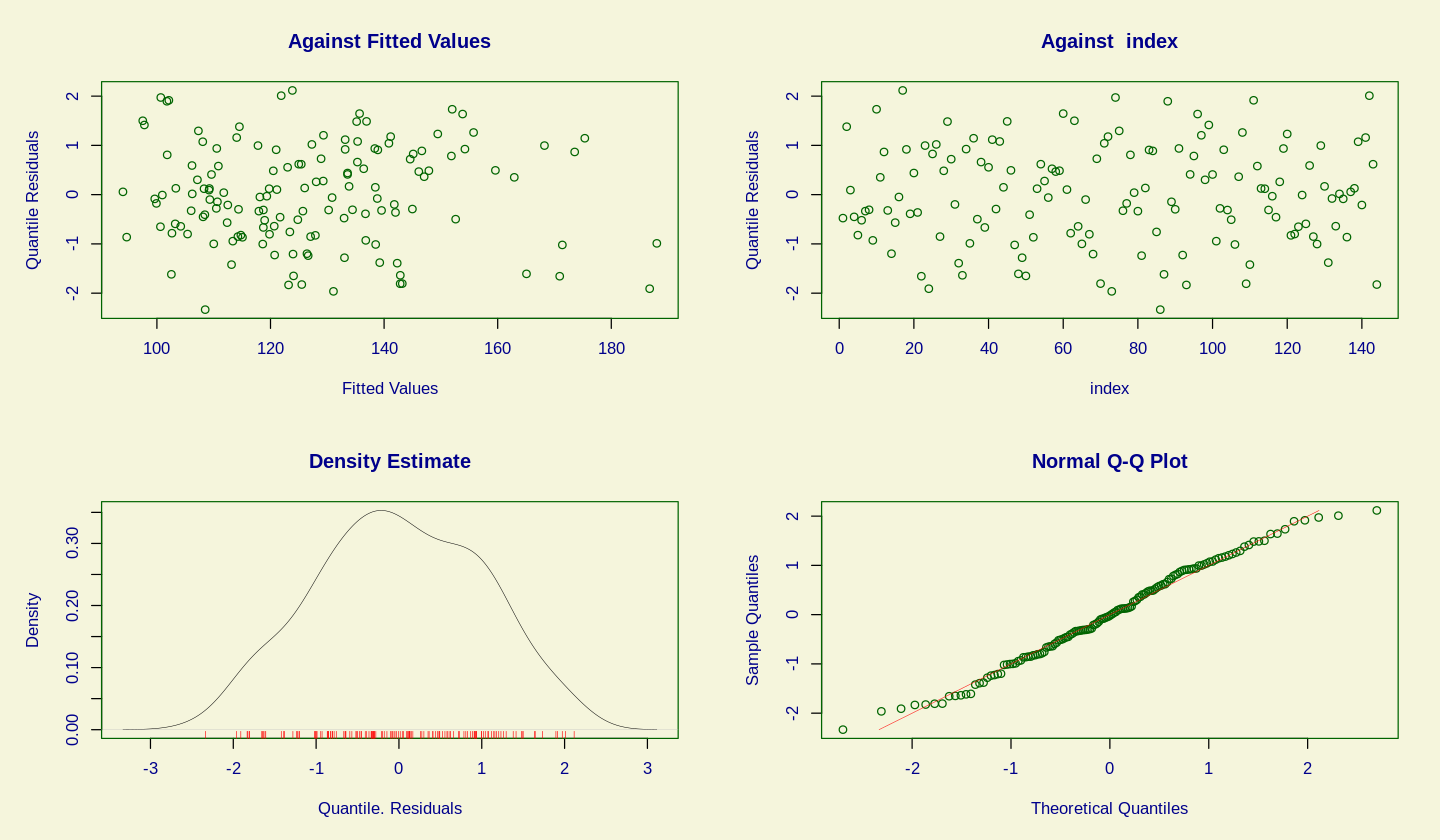

In [19]:
# Evaluate diagnostic plots
options(repr.plot.width = 12, repr.plot.height = 7)
par(mfrow = c(2,2))
plot(gamlss_model)
par(mfrow = c(1,1))

In [20]:
# Evaluate information criteria metrics
aic <- AIC(gamlss_model)
bic <- GAIC(gamlss_model, k = log(nrow(train_data)))  # BIC = GAIC with k = log(n))

# Calculate Pseudo R-squared
Rsq_values <- Rsq(gamlss_model, type = "both")

# Extract the R-squared values
Rsq_CoxSnell <- Rsq_values$CoxSnell
Rsq_CraggUhler <- Rsq_values$CraggUhler

# Create a dataframe with the metrics
metrics_df <- data.frame(
  Metric = c("AIC", "BIC", "Rsq_CoxSnell", "Rsq_CraggUhler"),
  Value = c(aic, bic, Rsq_CoxSnell, Rsq_CraggUhler)
)

# Print the dataframe
metrics_df

Metric,Value
<chr>,<dbl>
AIC,1228.3624423
BIC,1287.7587083
Rsq_CoxSnell,0.6107288
Rsq_CraggUhler,0.6107907


# Model Predictions

In [21]:
# Obtain mean response predictions
predictions_mean <- predict(
  gamlss_model,
  newdata = test_data,
  type = "response",
  what = "mu"
)

In [22]:
# Obtain sigma predictions
predictions_sigma <- predict(
  gamlss_model,
  newdata = test_data,
  type = "response",
  what = "sigma"
)

In [23]:
# Simulate predictions for prediction intervals
if (!is.null(predictions_sigma)) {
  set.seed(123)
  n_sim <- 1000
  simulated_values <- replicate(n_sim, {
    rNBI(n = nrow(test_data), mu = predictions_mean, sigma = predictions_sigma)
  })

  predictions_lower <- apply(simulated_values, 1, quantile, probs = 0.025)
  predictions_upper <- apply(simulated_values, 1, quantile, probs = 0.975)
} else {
  predictions_lower <- NA
  predictions_upper <- NA
}

In [24]:
# Evaluate predictive metrics
actual <- test_data$drivers_killed
errors <- actual - predictions_mean

MSE <- mean(errors^2)
RMSE <- sqrt(MSE)
MAE <- mean(abs(errors))
MAPE <- mean(abs(errors / actual)) * 100

# Print predictive metrics
cat("MSE:", MSE, "\n")
cat("RMSE:", RMSE, "\n")
cat("MAE:", MAE, "\n")
cat("MAPE(%):", MAPE, "\n")

MSE: 232.3396 
RMSE: 15.24269 
MAE: 11.37832 
MAPE(%): 10.96739 


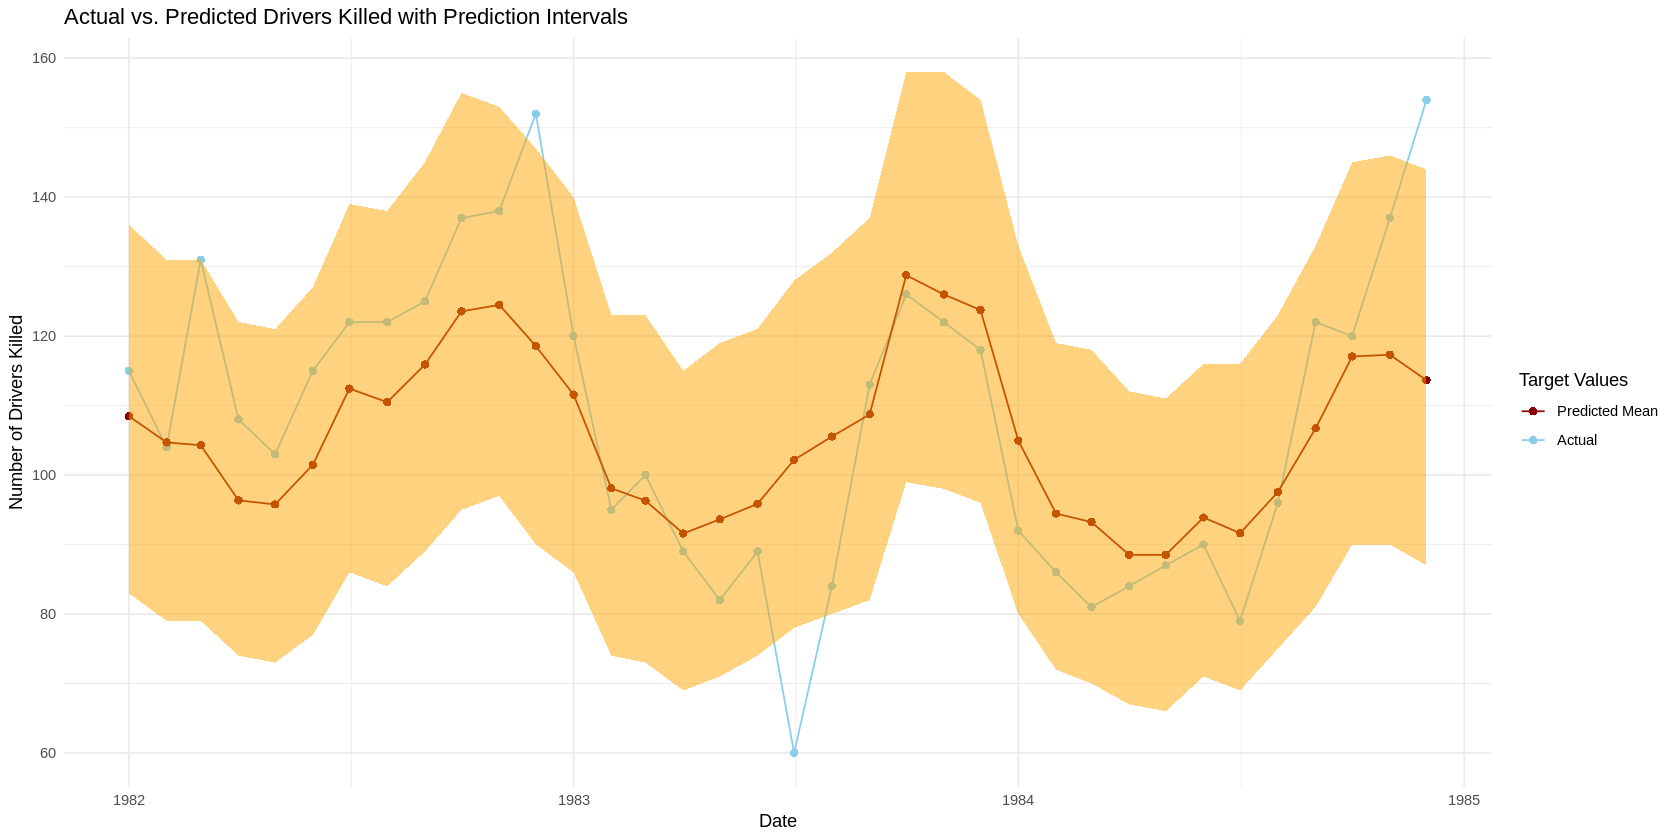

In [25]:
# Plot actual test set values versus predicted values
test_data$predictions_mean <- predictions_mean
test_data$predictions_lower <- predictions_lower
test_data$predictions_upper <- predictions_upper

options(repr.plot.width = 14, repr.plot.height = 7)
ggplot(test_data, aes(x = date)) +
  # Actual values line and points
  geom_line(aes(y = drivers_killed, color = "Actual")) +
  geom_point(aes(y = drivers_killed, color = "Actual"), shape = 16, size = 2) +

  # Predicted mean line and points
  geom_line(aes(y = predictions_mean, color = "Predicted Mean")) +
  geom_point(aes(y = predictions_mean, color = "Predicted Mean"), shape = 16, size = 2) +

  # Prediction intervals ribbon
  geom_ribbon(aes(ymin = predictions_lower, ymax = predictions_upper), fill = "orange", alpha = 0.5) +

  # Titles and labels
  ggtitle("Actual vs. Predicted Drivers Killed with Prediction Intervals") +
  xlab("Date") + ylab("Number of Drivers Killed") +

  # Manual color scale
  scale_color_manual(
    name = "Target Values",
    values = c("Actual" = "skyblue", "Predicted Mean" = "darkred")
  ) +

  # Minimal theme
  theme_minimal() +

  # Reverse the legend order
  guides(color = guide_legend(reverse = TRUE))

# Model Comparison

In [26]:
# List to store model configurations
model_configs <- list()

# Configuration 1: Full model
model_configs[["Full Model"]] <- all_predictors

# Configuration 2: Remove trend spline terms
model_configs[["Without Trend Spline"]] <- setdiff(all_predictors, spline_vars)

# Configuration 3: Remove seasonality terms
model_configs[["Without Seasonality"]] <- setdiff(all_predictors, c("month_sin", "month_cos"))

# Configuration 4: Remove exogenous variables' lags
exog_vars <- c(paste0("lag_PetrolPrice_", lag_steps), paste0("lag_kms_", lag_steps))
model_configs[["Without Exogenous Variables"]] <- setdiff(all_predictors, exog_vars)

# Configuration 5: Remove PetrolPrice lags
petrol_vars <- paste0("lag_PetrolPrice_", lag_steps)
model_configs[["Without PetrolPrice Lags"]] <- setdiff(all_predictors, petrol_vars)

# Configuration 6: Remove kms lags
kms_vars <- paste0("lag_kms_", lag_steps)
model_configs[["Without kms Lags"]] <- setdiff(all_predictors, kms_vars)

# Configuration 7: Remove all lag 1 variables
lag1_vars <- c("lag_drivers_killed_1", "lag_PetrolPrice_1", "lag_kms_1")
model_configs[["Without Lag 1 Variables"]] <- setdiff(all_predictors, lag1_vars)

# Configuration 8: Remove all lag 3 variables
lag3_vars <- c("lag_drivers_killed_3", "lag_PetrolPrice_3", "lag_kms_3")
model_configs[["Without Lag 3 Variables"]] <- setdiff(all_predictors, lag3_vars)

# Configuration 9: Remove all lag 6 variables
lag6_vars <- c("lag_drivers_killed_6", "lag_PetrolPrice_6", "lag_kms_6")
model_configs[["Without Lag 6 Variables"]] <- setdiff(all_predictors, lag6_vars)

# Configuration 10: Remove all lag 12 variables
lag12_vars <- c("lag_drivers_killed_12", "lag_PetrolPrice_12", "lag_kms_12")
model_configs[["Without Lag 12 Variables"]] <- setdiff(all_predictors, lag12_vars)

In [27]:
# Function to calculate model performance metrics
calculate_metrics <- function(actual, predicted) {
  errors <- actual - predicted
  MSE <- mean(errors^2)
  RMSE <- sqrt(MSE)
  MAE <- mean(abs(errors))
  MAPE <- mean(abs(errors / actual)) * 100
  data.frame(MSE = MSE, RMSE = RMSE, MAE = MAE, MAPE = MAPE)
}

In [28]:
# Data frame to store performance metrics
performance_metrics <- data.frame()

# Loop over each model configuration
for (config_name in names(model_configs)) {
  predictors <- model_configs[[config_name]]

  # Check if predictors are not empty
  if (length(predictors) == 0) {
    cat("No predictors left for configuration:", config_name, "\n")
    next
  }

  # Define the formula for the current model configuration
  formula_mu <- as.formula(paste("drivers_killed ~", paste(predictors, collapse = " + ")))

  # Fit the model
  gamlss_model <- gamlss(
    formula = formula_mu,
    family = family_dist,
    data = train_data,
    control = gamlss.control(n.cyc = 100)
  )

  # Initialize newdata as an empty dataframe with the same number of rows as test_data
  newdata <- test_data[, 0]

  # If spline terms are included, we need to compute them
  if (any(grepl("trend_ns", predictors))) {
    # Ensure 'trend' is in newdata
    newdata$trend <- test_data$trend

    # Compute spline basis functions for the test data
    spline_basis_test <- predict(spline_basis_train, newx = newdata$trend)
    spline_basis_test_df <- as.data.frame(spline_basis_test)
    colnames(spline_basis_test_df) <- colnames(spline_basis_train_df)

    # Add spline basis functions to newdata
    newdata <- cbind(newdata, spline_basis_test_df)
  }

  # If 'month_sin' or 'month_cos' are in the predictors, compute them
  if ("month_sin" %in% predictors || "month_cos" %in% predictors) {
    # Ensure 'trend' is available
    if (!"trend" %in% names(newdata)) {
      newdata$trend <- test_data$trend
    }
    # Compute harmonic terms
    if ("month_sin" %in% predictors) {
      newdata$month_sin <- sin(2 * pi * newdata$trend / 12)
    }
    if ("month_cos" %in% predictors) {
      newdata$month_cos <- cos(2 * pi * newdata$trend / 12)
    }
  }

  # Add lag variables that are in the predictors
  lag_predictors <- predictors[predictors %in% names(test_data)]
  if (length(lag_predictors) > 0) {
    newdata <- cbind(newdata, test_data[, lag_predictors, drop = FALSE])
  }

  # Ensure newdata includes only the required predictors
  required_vars <- predictors
  missing_vars <- setdiff(required_vars, names(newdata))
  if (length(missing_vars) > 0) {
    cat("Warning: The following variables are missing in newdata for configuration", config_name, ":", paste(missing_vars, collapse = ", "), "\n")
    next
  }

  # Subset newdata to include only the required predictors
  newdata <- newdata[, required_vars, drop = FALSE]

  # Make predictions on the test data
  predictions <- predict(
    gamlss_model,
    newdata = newdata,
    type = "response",
    what = "mu"
  )

  # Calculate performance metrics
  metrics <- calculate_metrics(test_data$drivers_killed, predictions)
  metrics$Model <- config_name

  # Append to the performance_metrics data frame
  performance_metrics <- rbind(performance_metrics, metrics)
}

GAMLSS-RS iteration 1: Global Deviance = 1188.427 
GAMLSS-RS iteration 2: Global Deviance = 1188.362 
GAMLSS-RS iteration 3: Global Deviance = 1188.362 
GAMLSS-RS iteration 1: Global Deviance = 1193.208 
GAMLSS-RS iteration 2: Global Deviance = 1193.168 
GAMLSS-RS iteration 3: Global Deviance = 1193.168 
GAMLSS-RS iteration 1: Global Deviance = 1193.54 
GAMLSS-RS iteration 2: Global Deviance = 1193.493 
GAMLSS-RS iteration 3: Global Deviance = 1193.493 
GAMLSS-RS iteration 1: Global Deviance = 1192.735 
GAMLSS-RS iteration 2: Global Deviance = 1192.689 
GAMLSS-RS iteration 3: Global Deviance = 1192.689 
GAMLSS-RS iteration 1: Global Deviance = 1191.434 
GAMLSS-RS iteration 2: Global Deviance = 1191.393 
GAMLSS-RS iteration 3: Global Deviance = 1191.393 
GAMLSS-RS iteration 1: Global Deviance = 1190.564 
GAMLSS-RS iteration 2: Global Deviance = 1190.496 
GAMLSS-RS iteration 3: Global Deviance = 1190.496 
GAMLSS-RS iteration 1: Global Deviance = 1193.62 
GAMLSS-RS iteration 2: Global Dev

In [31]:
# Reshape the dataframe for plotting
performance_long <- melt(
  performance_metrics,
  id.vars = "Model",
  variable.name = "Metric",
  value.name = "Value"
)

# Filter out MSE
performance_long <- performance_long %>% filter(Metric != "MSE")

# Round the metric values to one decimal place
performance_long$Value <- sprintf("%.1f", round(performance_long$Value, 1))

# Order the models based on RMSE
ordering <- performance_long %>%
  filter(Metric == "RMSE") %>%
  arrange(as.numeric(Value)) %>%
  pull(Model)

# Set the factor levels of Model based on ordering
performance_long$Model <- factor(performance_long$Model, levels = ordering)

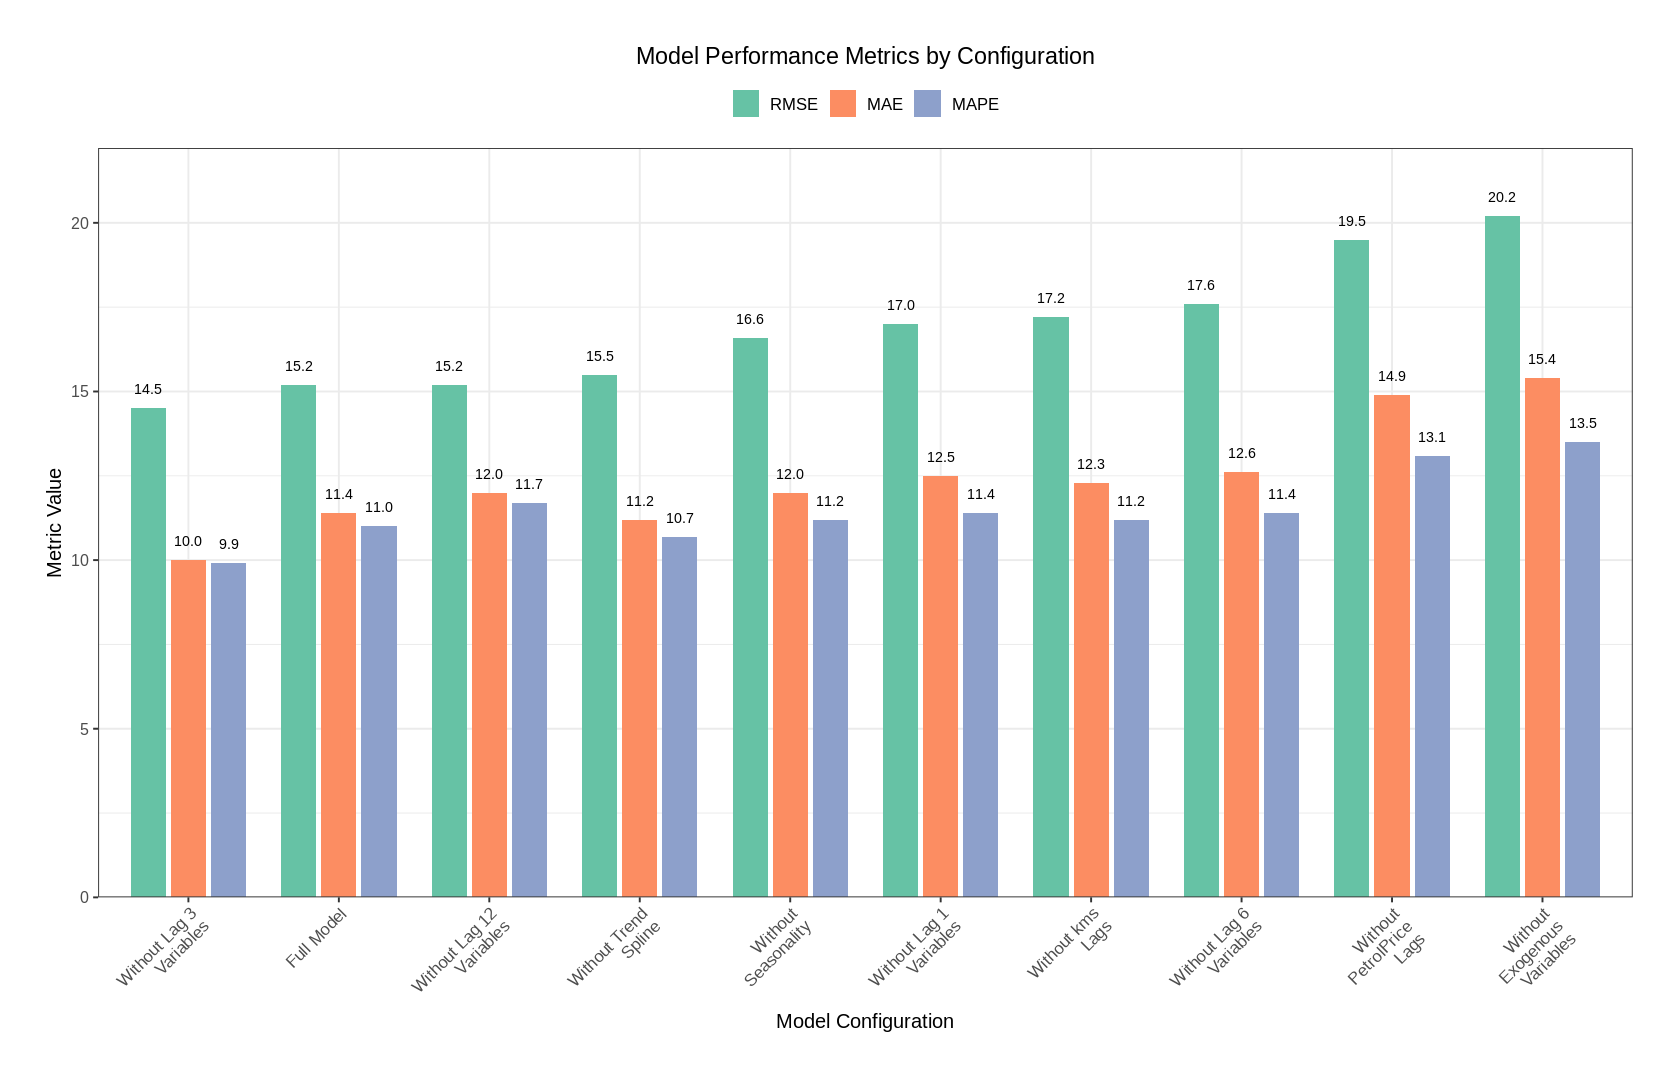

In [32]:
# Metrics comparison plot
options(repr.plot.width = 14, repr.plot.height = 9)
performance_plot <- ggplot(performance_long, aes(x = Model, y = as.numeric(Value), fill = Metric)) +
  geom_bar(stat = "identity", position = position_dodge(width = 0.8), width = 0.7) +
  labs(
    title = "Model Performance Metrics by Configuration",
    x = "Model Configuration",
    y = "Metric Value"
  ) +
  theme_bw(base_size = 12) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 10, vjust = 1),
    plot.title = element_text(hjust = 0.5, size = 14),
    legend.position = "top",
    legend.title = element_blank(),
    legend.text = element_text(size = 10),
    plot.margin = margin(1, 1, 1, 1, "cm")
  ) +
  scale_fill_brewer(palette = "Set2") +
  geom_text(
    aes(label = Value),
    position = position_dodge(width = 0.8),
    vjust = -1.4,
    angle = 0,
    size = 3
  ) +
  scale_y_continuous(
    expand = expansion(mult = c(0, 0.1)),
    breaks = pretty_breaks(n = 5)
  ) +
  scale_x_discrete(labels = function(x) str_wrap(x, width = 15))

# Display the plot
print(performance_plot)